### Module 2: Hedge Validation
We test whether bonds failed as a hedge (correlation spiked in 2022) and whether gold stayed low/negative correlation vs equities.
We plot Rolling 12-Month Correlation:

SPY vs BND

SPY vs IAU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read daily returns
df = pd.read_csv("../processed/etf_returns.csv", parse_dates=["Date"])
df = df[["Date", "Ticker", "Daily_Return"]].dropna()

# Convert to wide: Date index, tickers as columns
returns_wide = df.pivot(index="Date", columns="Ticker", values="Daily_Return").sort_index()

print("Date range:", returns_wide.index.min(), "to", returns_wide.index.max())
print("Columns available:", len(returns_wide.columns))
returns_wide.head()

Date range: 2014-01-03 00:00:00 to 2026-01-30 00:00:00
Columns available: 12


Ticker,BND,IAU,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO,ZLB.TO
Date,,,,,,,,,,,,
2014-01-03,0.000125,0.010943,0.001377,0.000610,-0.000164,-0.002212,0.003350,-0.003174,-0.000210,-0.002796,0.000661,-0.000989
2014-01-06,0.000874,0.000000,-0.003576,-0.003053,-0.002898,-0.004064,-0.008013,-0.001158,-0.002630,-0.004205,0.000662,-0.001483
2014-01-07,0.001247,-0.004996,0.005522,0.007348,0.006142,0.010015,0.005048,0.018256,0.006434,0.008446,0.002642,0.009906
2014-01-08,-0.003238,-0.005021,-0.003570,-0.004255,0.000218,0.001469,-0.001339,0.001992,0.000734,0.000931,0.000658,0.001471
2014-01-09,0.001874,0.002523,0.001653,0.004273,0.000654,-0.000734,0.004694,0.005112,0.000838,0.000930,-0.000658,0.000980


In [2]:
# sanity check
needed = ["SPY", "BND", "IAU"]
missing = [t for t in needed if t not in returns_wide.columns]
print("Missing ticker:", missing)

# keep only needed column that exist 
cols = [t for t in needed if t in returns_wide.columns]
data = returns_wide[cols].dropna()
print("Data shape after dropna:", data.shape)
data.head()

Missing ticker: []
Data shape after dropna: (3037, 3)


Ticker,SPY,BND,IAU
Date,,,
2014-01-03,-0.000164,0.000125,0.010943
2014-01-06,-0.002898,0.000874,0.000000
2014-01-07,0.006142,0.001247,-0.004996
2014-01-08,0.000218,-0.003238,-0.005021
2014-01-09,0.000654,0.001874,0.002523


In [3]:
WINDOW = 252  # ~12 months trading days

spy = data["SPY"]

# Rolling correlations
corr_spy_bnd = spy.rolling(WINDOW).corr(data["BND"]) if "BND" in data.columns else None
corr_spy_iau = spy.rolling(WINDOW).corr(data["IAU"]) if "IAU" in data.columns else None
corr_spy_gld = spy.rolling(WINDOW).corr(data["GLD"]) if "GLD" in data.columns else None

# Combine for easy plotting
corr_df = pd.DataFrame({
    "SPY vs BND": corr_spy_bnd,
    "SPY vs IAU": corr_spy_iau,
    "SPY vs GLD": corr_spy_gld
}).dropna(how="all")

corr_df.head()


,SPY vs BND,SPY vs IAU,SPY vs GLD
Date,,,
2015-01-02,-0.359117,-0.154892,None
2015-01-05,-0.368894,-0.169274,None
2015-01-06,-0.373862,-0.173891,None
2015-01-07,-0.372960,-0.175054,None
2015-01-08,-0.381641,-0.176629,None


- Bonds moved meaningfully positive during 2022 (not a reliable hedge in that regime).
- Gold stayed closer to zero (and sometimes negative), meaning it behaved more like a diversifier than bonds in that stress window.

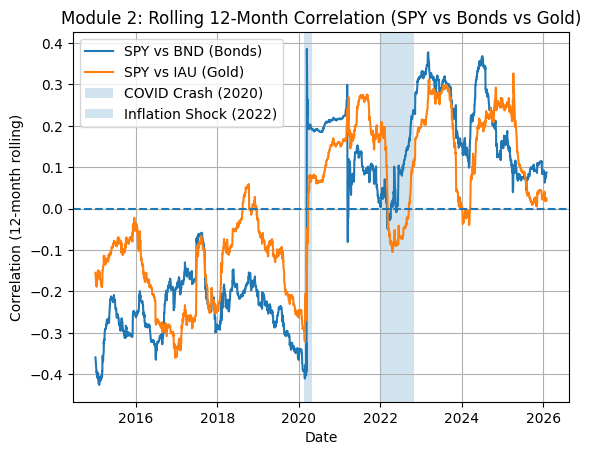

In [4]:
plt.figure()

if "SPY vs BND" in corr_df.columns and corr_df["SPY vs BND"].notna().any():
    plt.plot(corr_df.index, corr_df["SPY vs BND"], label="SPY vs BND (Bonds)")

if "SPY vs IAU" in corr_df.columns and corr_df["SPY vs IAU"].notna().any():
    plt.plot(corr_df.index, corr_df["SPY vs IAU"], label="SPY vs IAU (Gold)")

if "SPY vs GLD" in corr_df.columns and corr_df["SPY vs GLD"].notna().any():
    plt.plot(corr_df.index, corr_df["SPY vs GLD"], label="SPY vs GLD (Gold)")

# Zero line
plt.axhline(0, linestyle="--")

# Crisis shading (simple + readable)
plt.axvspan(pd.to_datetime("2020-02-15"), pd.to_datetime("2020-04-30"), alpha=0.2, label="COVID Crash (2020)")
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-10-31"), alpha=0.2, label="Inflation Shock (2022)")

plt.title("Module 2: Rolling 12-Month Correlation (SPY vs Bonds vs Gold)")
plt.xlabel("Date")
plt.ylabel("Correlation (12-month rolling)")
plt.savefig("../outputs/module2_rolling_corr.png", dpi=200, bbox_inches="tight")
plt.legend()
plt.grid(True)
plt.show()


- Rolling correlation shows bond correlation rises in 2022, meaning the hedge relationship broke.
- Ensemble tests confirm the same story:
    - In down markets, BND downside capture increases (bad).
    - In crash days, IAU tail beta is lower than BND (better hedge behavior).
- Therefore, IAU is the preferred hedge for the Defensive Growth portfolio.

In [5]:
start_2022 = "2022-01-01"
end_2022 = "2022-12-31"

corr_2022 = corr_df.loc[start_2022:end_2022].agg(["mean", "median", "min", "max"])
display(corr_2022)


,SPY vs BND,SPY vs IAU,SPY vs GLD
mean,0.112376,0.034017,NaN
median,0.091035,-0.020984,NaN
min,-0.047114,-0.104945,NaN
max,0.320968,0.209645,NaN


- Bonds “fail” if SPY vs BND correlation becomes positive and high during stress.
- Gold “works” if SPY vs IAU stays closer to 0 or negative during stress.

## Ensemble Hedge Validation (IAU vs BND)

- Validate that BND fails as a hedge in the 2022 regime.
- Validate that IAU behaves more like a diversifier during stress.
- Use an ensemble of 3 tests: correlation + downside capture + tail beta.

In [6]:
cad_needed = ["VDY.TO", "ZLB.TO", "XIC.TO"]
cad_missing = [t for t in cad_needed if t not in returns_wide.columns]
print("Missing CAD tickers:", cad_missing)

if len(cad_missing) == 0:
    cad = returns_wide[cad_needed].dropna()
    var_mkt = cad["XIC.TO"].var()
    beta_vdy = cad[["VDY.TO","XIC.TO"]].cov().loc["VDY.TO","XIC.TO"] / var_mkt
    beta_zlb = cad[["ZLB.TO","XIC.TO"]].cov().loc["ZLB.TO","XIC.TO"] / var_mkt

    print(f"VDY.TO Beta vs XIC.TO: {beta_vdy:.2f}")
    print(f"ZLB.TO Beta vs XIC.TO: {beta_zlb:.2f}")
    print("Winner for Defensive Growth:", "ZLB.TO" if beta_zlb < beta_vdy else "VDY.TO")


Missing CAD tickers: []
VDY.TO Beta vs XIC.TO: 0.98
ZLB.TO Beta vs XIC.TO: 0.70
Winner for Defensive Growth: ZLB.TO


In [7]:
def downside_capture(asset, benchmark):
    """
    Downside Capture (%): How much the hedge moves when benchmark days are negative.
    Lower is better. Negative is excellent (hedge tends to rise when market falls).
    """
    mask = benchmark < 0
    if mask.sum() < 10:
        return np.nan
    b = benchmark[mask].mean()
    a = asset[mask].mean()
    return (a / b) * 100  # b is negative; sign matters

def tail_beta(asset, benchmark, q=0.05):
    """
    Tail Beta: beta computed only on worst q% benchmark days.
    Lower is better. Negative suggests insurance-like behavior.
    """
    threshold = benchmark.quantile(q)
    mask = benchmark <= threshold
    if mask.sum() < 10:
        return np.nan
    cov = np.cov(asset[mask], benchmark[mask], ddof=0)[0, 1]
    var = np.var(benchmark[mask], ddof=0)
    return cov / var if var != 0 else np.nan

In [8]:
hedge_needed = ["SPY", "BND", "IAU"]
missing = [t for t in hedge_needed if t not in returns_wide.columns]
print("Missing hedge tickers:", missing)

hedge = returns_wide[hedge_needed].dropna()
spy = hedge["SPY"]

def run_ensemble(label, sub_df):
    spy_sub = sub_df["SPY"]
    out = []
    for h in ["BND", "IAU"]:
        out.append({
            "Period": label,
            "Hedge": h,
            "Downside Capture (%)": downside_capture(sub_df[h], spy_sub),
            "Tail Beta (worst 5%)": tail_beta(sub_df[h], spy_sub, q=0.05),
        })
    return pd.DataFrame(out)

ensemble_full = run_ensemble("Full", hedge)

hedge_2022 = hedge.loc["2022-01-01":"2022-12-31"].dropna()
ensemble_2022 = run_ensemble("2022", hedge_2022)

ensemble_df = pd.concat([ensemble_full, ensemble_2022], ignore_index=True)
ensemble_df

Missing hedge tickers: []


,Period,Hedge,Downside Capture (%),Tail Beta (worst 5%)
0,Full,BND,-0.270416,0.162586
1,Full,IAU,-6.195708,0.228161
2,2022,BND,13.563265,0.195967
3,2022,IAU,4.287244,0.803260


<Figure size 640x480 with 0 Axes>

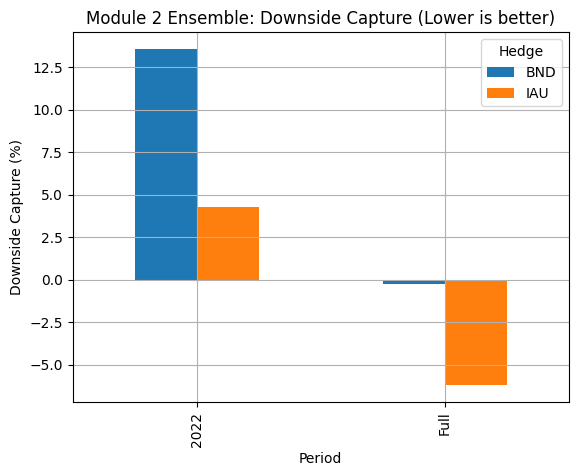

<Figure size 640x480 with 0 Axes>

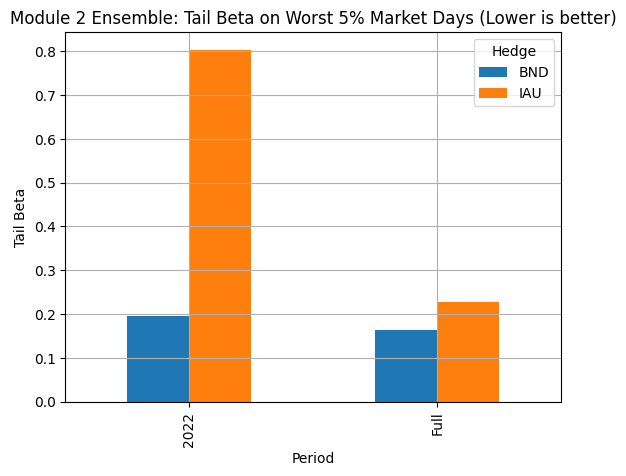

In [9]:
# Pivot for plotting
pivot = ensemble_df.pivot(index=["Period"], columns="Hedge", values="Downside Capture (%)")
pivot2 = ensemble_df.pivot(index=["Period"], columns="Hedge", values="Tail Beta (worst 5%)")

plt.figure()
pivot.plot(kind="bar")
plt.title("Module 2 Ensemble: Downside Capture (Lower is better)")
plt.ylabel("Downside Capture (%)")
plt.grid(True)
plt.show()

plt.figure()
pivot2.plot(kind="bar")
plt.title("Module 2 Ensemble: Tail Beta on Worst 5% Market Days (Lower is better)")
plt.ylabel("Tail Beta")
plt.grid(True)
plt.show()

### Canadian Stand-off (CAD Core Slot): VDY.TO vs ZLB.TO
We pick the Canadian ETF that best fits Defensive Growth.
Decision rule: choose the ETF with lower beta to the Canadian market benchmark (XIC.TO).

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("../processed/etf_returns.csv", parse_dates=["Date"])
df = df[["Date", "Ticker", "Daily_Return"]].dropna()
returns_wide = df.pivot(index="Date", columns="Ticker", values="Daily_Return").sort_index()

returns_wide.head()

Ticker,BND,IAU,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO,ZLB.TO
Date,,,,,,,,,,,,
2014-01-03,0.000125,0.010943,0.001377,0.000610,-0.000164,-0.002212,0.003350,-0.003174,-0.000210,-0.002796,0.000661,-0.000989
2014-01-06,0.000874,0.000000,-0.003576,-0.003053,-0.002898,-0.004064,-0.008013,-0.001158,-0.002630,-0.004205,0.000662,-0.001483
2014-01-07,0.001247,-0.004996,0.005522,0.007348,0.006142,0.010015,0.005048,0.018256,0.006434,0.008446,0.002642,0.009906
2014-01-08,-0.003238,-0.005021,-0.003570,-0.004255,0.000218,0.001469,-0.001339,0.001992,0.000734,0.000931,0.000658,0.001471
2014-01-09,0.001874,0.002523,0.001653,0.004273,0.000654,-0.000734,0.004694,0.005112,0.000838,0.000930,-0.000658,0.000980


In [11]:
cad_needed = ["VDY.TO", "ZLB.TO", "XIC.TO"]
missing = [t for t in cad_needed if t not in returns_wide.columns]
print("Missing:", missing)

Missing: []


In [14]:
cad = returns_wide[cad_needed].dropna()
print("CAD data shape:", cad.shape)
print("Date range", cad.index.min(), "to", cad.index.max())

market = cad["XIC.TO"]

CAD data shape: (3031, 3)
Date range 2014-01-03 00:00:00 to 2026-01-30 00:00:00


In [13]:
cad.head(10)

Ticker,VDY.TO,ZLB.TO,XIC.TO
Date,,,
2014-01-03,0.003350,-0.000989,-0.002796
2014-01-06,-0.008013,-0.001483,-0.004205
2014-01-07,0.005048,0.009906,0.008446
2014-01-08,-0.001339,0.001471,0.000931
2014-01-09,0.004694,0.000980,0.000930
2014-01-10,0.001335,0.002935,0.008360
2014-01-13,-0.004000,-0.002439,-0.004606
2014-01-14,-0.000670,0.000978,0.002776
2014-01-15,0.002010,0.002931,0.004615


In [ ]:
marker = cad["XIC.TO"]
var_mkt = market.var()


- XIC.TO is the iShares Core S&P/TSX Capped Composite Index ETF.
- What it represents: The entire Canadian stock market (The "Average").
- Why we use it: If you buy XIC, you get the market result. We are trying to beat the market result—specifically by being safer.
    - If ZLB drops more than XIC during a crash, it fails.
    - If ZLB drops less than XIC, it wins.
